In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from os.path import join, exists, isdir, isfile
from os import listdir, mkdir
import regex as re
from random import shuffle
%matplotlib notebook

#Система Си
ms, mV   = (1e-3, 1e-3)
mcs, mcV = (1e-6, 1e-6)
dt = 1e-5

def _find_jumps (t, V, boxA, boxj, deadj):
    '''
    This function takes in an array of time values (t) and an array of voltage values (V),
    as well as optional parameters for box amplitude (boxA), box jumps (boxj), and dead time (deadj).
    It then uses these parameters to find the indices of voltage jumps that exceed the box amplitude,
    returning them as a numpy array.

    :param t: numpy array of time values
    :param V: numpy array of voltage values
    :param boxA: float value for box amplitude (default 1.0)
    :param boxj: integer value for box jumps (default 10)
    :param deadj: integer value for dead time (default 1)
    :return: numpy array of indices representing voltage jumps that exceed the box amplitude
    '''
    jumps = np.array([], dtype = int)
    j = 0
    while j < len(V)-boxj:
        if V[j+boxj] - V[j] > boxA:
            jumps = np.append(jumps, j+boxj)
            j+=deadj
        j+=1
            
    return jumps
    
def box_parcer(t: np.ndarray, V: np.ndarray, boxA=1.0, boxj=10, dead_time=250*mcs, live_time=70*ms):
    '''
    This function takes in an array of time values (t) and an array of voltage values (V),
    as well as optional parameters for box amplitude (boxA), box jumps (boxj), dead time (dead_time),
    and live time (live_time). It then uses these parameters to parse the input data into left
    and right box stimuli, returning them as a tuple.

    :param t: numpy array of time values
    :param V: numpy array of voltage values
    :param boxA: float value for box amplitude (default 1.0)
    :param boxj: integer value for box jumps (default 10)
    :param dead_time: float value for dead time (default 250*mcs)
    :param live_time: float value for live time (default 70*ms)
    :return: tuple of numpy arrays representing left and right box stimuli
    '''
    boxA = np.float32(boxA)
    boxj = int(boxj)
    dead_time = np.float32(dead_time)
    live_time = np.float32(live_time)
    deadj = int((dead_time+live_time)/dt)
    
    jumps = _find_jumps(t, V, boxA, boxj, deadj)
    output_lefts  = np.array([[np.array([t[j] for j in range(int(i+dead_time/dt), int(i+live_time/dt))]), 
                        np.array([V[j] for j in range(int(i+dead_time/dt), int(i+live_time/dt))])] for i in jumps[1::2]])
    output_rights = np.array([[np.array([t[j] for j in range(int(i+dead_time/dt), int(i+live_time/dt))]), 
                        np.array([V[j] for j in range(int(i+dead_time/dt), int(i+live_time/dt))])] for i in jumps[ ::2]])
    
    output = (output_lefts, output_rights)
    
    return output

import time
from warnings import warn

def _equispaced (T):
    '''
    This function takes in a numpy array of time values (T) and checks if the values are equispaced.
    It returns 1 if the values are equispaced and 0 otherwise.

    :param T: numpy array of time values
    :return: integer value 1 if time values are equispaced, 0 otherwise    
    '''
    w = T[1] - T[0]
    for j in range(len(T) - 1):
        if T[j+1] - T[j] == w:
            continue
        else:
            return 0
    return 1

def average_filter (t, V, amp_c=0.005, width=20, check=True, cut=50):
    '''
    Linear average filter for burst signal with amplitude level control.
    ----------------------------------------------------------------
    Input:
        V      - voltage data                                   ; np.array like
        t      - counts equispaced data                         ; np.array like
        amp_c  - critical level for amplitude not to be averaged; float
        width  - number of counts to be averaged                ; int
        check  - to test data or not                            ; bool
    ----------------------------------------------------------------
    Output:
        df['V', 't'] - filtered signal                          ; np.array(shape=(N, 2))
    '''
    V = np.array(V)
    t = np.array(t)
    if check:
        assert len(V) == len(t), 'V and t must have same len'
    
        assert _equispaced(t)  , 'data must be equispaced'
        print('test completed')
        print('--------------------')
        #warn('No tests')
    size = len(V)
    amp_c = np.float32(amp_c)
    width = int(width)
    lin = lambda x, a, b: a*x + b
    
    output = np.array([t, np.zeros(size)])
    for j in np.arange(0, size-width, width):
        j = int(j)
        if np.max(V[j:j+width]) - np.min(V[j:j+width]) < amp_c:
            p, _ = curve_fit(lin, t[j:j+width], V[j:j+width])
            output[1][j:j+width] = lin(t[j:j+width], p[0], p[1])
        else:
            output[1][j:j+width] = V[j:j+width]
    return output[:, :len(t)-cut]

def hampel(vals_orig):
    '''
    This function applies the Hampel filter to a numpy array of values (valsorig) to detect and remove outliers.
    It returns the filtered values with outliers replaced by NaN.

    :param valsorig: numpy array of values
    :return: numpy array of filtered values with outliers replaced by NaN    
    '''
    vals = vals_orig.copy()    
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

def check_sample(sample_name, name):
    output = name.find(sample_name)
    if output == -1:
        return 0;
    else:
        return 1;

def path_find (date : str, sample_names : list):
    series_names = listdir(join('DATA', 'relaxometry', date))
    try:
        series_names.remove('.ipynb_checkpoints')
    except:
        pass
    
    series_paths = list([])
    for series_name in series_names:
        names = [j + '\\0.txt' for j in listdir(join('DATA', 'relaxometry', date, series_name))]
        names.remove('noise\\0.txt')
        try:
            names.remove('.ipynb_checkpoints')
        except:
            pass
        
        sample_paths = list([])
        for sample_name in sample_names:
            
            paths = list([])
            for name in names:
                path = join('DATA', 'relaxometry', date, series_name, name)
                if check_sample(sample_name, name) and exists(path):
                    paths.append(path)
            sample_paths.append(paths)
        
        nameNoise = 'noise\\0.txt'
        pathNoise = join('DATA', 'relaxometry', date, series_name, nameNoise)
        series_paths.append((pathNoise, sample_paths))
    return series_paths  

def file_in_Set(Set_paths, Noise_path):
    Set = list([])
    for path in Set_paths:
        data = pd.read_csv(path, names = ['V'])
        time = np.arange(len(data['V']))*dt
        data['t'] = time
        Set.append(data)

    Noise = pd.read_csv(Noise_path, names = ['V'])
    time = np.arange(len(Noise['V']))*dt
    Noise['t'] = time
    
    return (Set, Noise)

def f (offset):
    return lambda t, A1, A2, T1, T2: A1*np.exp(-t/T1) + A2*np.exp(-t/T2) + offset #сделать обработку offset

def f_noise (offset):
    return lambda t, A, T: A*np.exp(-t/T) + offset

def curve_processing(Set, Noise):
    """
    This function processes the given data sets by fitting curves to them and returning the results. 

    :param Set: A list of pandas dataframes containing the data sets to be processed.
    :param Noise: A pandas dataframe containing the noise data set.
    :return: A tuple of two lists of pandas dataframes. The first list contains the processed data for the left boxes 
        of each data set in Set, and the second list contains the processed data for the right boxes of each data set in Set.
    """
    L, R = box_parcer(Noise['t'].to_numpy(), Noise['V'].to_numpy())

    exp_data_N = pd.DataFrame(columns=('A', 'T', 'eA', 'eT', 'offset'))
    for data_i in np.concatenate((L, R), axis=0):
        X, Y = (data_i[0], data_i[1])
        offset = np.mean(Y[int(len(Y)-50):])
        popt, pcov = curve_fit(f_noise(offset), X-X[0], Y, bounds = ([-1, 1e-5], [1, 1.5e-3]))
        A, T = popt
        if all(j < 1 for j in np.sqrt(np.diag(pcov))):
            eA, eT = np.sqrt(np.diag(pcov))
            exp_data_N.loc[len(exp_data_N.index)] = [np.abs(A), T, eA, eT, offset]

    T1_0 = exp_data_N['T'].mean()

    SetA_R = list([])
    SetA_L = list([])
    #SetBad_L = list([])
    #SetBad_R = list([])

    for data in Set:
        L, R = box_parcer(data['t'].to_numpy(), data['V'].to_numpy())

        exp_data_R = pd.DataFrame(columns=('A1', 'A2', 'T1', 'T2', 'eA1', 'eA2', 'eT1', 'eT2', 'offset'))
        #bad_R = pd.DataFrame(columns=('A1', 'A2', 'T1', 'T2', 'eA1', 'eA2', 'eT1', 'eT2', 'offset'))
        for data_i in R:
            X, Y = (data_i[0], data_i[1])
            offset = np.mean(Y[int(len(Y)-50):])
            popt, pcov = curve_fit(f(offset), X-X[0], Y, 
                                   bounds = ([-1, -1, max([T1_0-1e-3, 1e-5]), 2e-3], [1, 1, T1_0+1e-3,  7e-2]))
            A1, A2, T1, T2 = popt
            if all(j < 1 for j in np.sqrt(np.diag(pcov))):
                eA1, eA2, eT1, eT2 = np.sqrt(np.diag(pcov))
                exp_data_R.loc[len(exp_data_R.index)] = [np.abs(A1), np.abs(A2), T1, T2, eA1, eA2, eT1, eT2, offset]
            '''
            else:
                eA1, eA2, eT1, eT2 = np.sqrt(np.diag(pcov))
                bad_R.loc[len(exp_data_R.index)] = [np.abs(A1), np.abs(A2), T1, T2, eA1, eA2, eT1, eT2, offset]
            '''

        exp_data_L = pd.DataFrame(columns=('A1', 'A2', 'T1', 'T2', 'eA1', 'eA2', 'eT1', 'eT2', 'offset'))
        #bad_L = pd.DataFrame(columns=('A1', 'A2', 'T1', 'T2', 'eA1', 'eA2', 'eT1', 'eT2', 'offset'))
        for data_i in L:
            X, Y = (data_i[0], data_i[1])
            offset = np.mean(Y[int(len(Y)-50):])
            popt, pcov = curve_fit(f(offset), X-X[0], Y, 
                                   bounds = ([-1, -1, max([T1_0-1e-3, 1e-5]), 2e-3], [1, 1, T1_0+1e-3,  7e-2]))
            A1, A2, T1, T2 = popt
            if all(j < 1 for j in np.sqrt(np.diag(pcov))):
                eA1, eA2, eT1, eT2 = np.sqrt(np.diag(pcov))
                exp_data_L.loc[len(exp_data_L.index)] = [np.abs(A1), np.abs(A2), T1, T2, eA1, eA2, eT1, eT2, offset]
            '''
            else:
                eA1, eA2, eT1, eT2 = np.sqrt(np.diag(pcov))
                bad_R.loc[len(exp_data_R.index)] = [np.abs(A1), np.abs(A2), T1, T2, eA1, eA2, eT1, eT2, offset]
            '''
        SetA_R.append(exp_data_R)
        SetA_L.append(exp_data_L)
        #SetBad_R.append(bad_R)
        #SetBad_L.append(bad_L)
    return ((SetA_L, SetA_R), (SetBad_L, SetBad_R))

def filtering (SetA : tuple):
    """
    This function filters noise from the given data sets by applying a Hampel filter to each column of the data frames. It then calculates the size and purity of each data set, and returns the filtered data sets along with their purities.

    :param SetA: A tuple containing two lists of pandas dataframes. The first list contains the data for the left boxes of each data set, and the second list contains the data for the right boxes of each data set.
    :return: A tuple containing two lists of pandas dataframes. The first list contains the filtered data for the left boxes of each data set in SetA, and the second list contains the filtered data for the right boxes of each data set in SetA. The tuple also contains a list of purities for each set, where purity is defined as the ratio of the size of the filtered set to the size of the original set.
    """
    SetA_L, SetA_R = SetA
    SetA_L_c = list([])
    for exp_data_L in SetA_L:
        exp_data_L_c = exp_data_L.copy()
        for x in ('A1', 'T1', 'A2', 'T2'):
            exp_data_L_c[x] = hampel(exp_data_L_c[x])
        exp_data_L_c = exp_data_L_c.dropna()
        SetA_L_c.append(exp_data_L_c)


    SetA_R_c = list([])
    for exp_data_R in SetA_R:
        exp_data_R_c = exp_data_R.copy()
        for x in ('A1', 'T1', 'A2', 'T2'):
            exp_data_R_c[x] = hampel(exp_data_R_c[x])
        exp_data_R_c = exp_data_R_c.dropna()
        SetA_R_c.append(exp_data_R_c)
        
    sizes_R_c = [j.count() for j in SetA_R_c]
    sizes_L_c = [j.count() for j in SetA_L_c]

    sizes_R = [j.count() for j in SetA_R]
    sizes_L = [j.count() for j in SetA_L]
    
    purity = ([round(j, 2) for j in np.array(np.mean(sizes_L_c, axis=1))/np.array(np.mean(sizes_L, axis=1))],
              [round(j, 2) for j in np.array(np.mean(sizes_R_c, axis=1))/np.array(np.mean(sizes_R, axis=1))])
    
    return ((SetA_L_c, SetA_R_c), purity)

def stat_analyze(SetA_c : tuple):
    """
    This function performs statistical analysis on the given data sets. It calculates the mean and standard 
        deviation of the 'A2' and 'T2' columns for each data set in SetA using a Gaussian fit. It returns 
        a tuple containing two tuples, each containing two lists of mean and standard deviation values for 
        the left and right boxes of each data set in SetA.

    :param SetA_c: A tuple containing two lists of pandas dataframes. The first list contains the data for 
        the left boxes of each data set, and the second list contains the data for the right boxes of each 
        data set.
    :return: A tuple containing two tuples, each containing two lists of mean and standard deviation values
        for the left and right boxes of each data set in SetA.
    """
    SetA_L_c, SetA_R_c = SetA_c
    Set_mu_L = list([])
    Set_sigma_L = list([])

    for exp_data_L_c in SetA_L_c:

        binsN = 25
        res_mu = np.zeros(2)
        res_sigma = np.zeros(2)
        j = 0
        for x in ('A2', 'T2'):    
            hist = np.histogram(exp_data_L_c[x], bins=binsN)
            X = np.array([(hist[1][j+1]+hist[1][j])/2 for j in range(len(hist[1])-1)])
            Y = hist[0]

            gaussA = lambda x, mu, sigma, A: A/(sigma*np.sqrt(2*np.pi)) *np.exp(-0.5*((x-mu)/(sigma))**2)

            popt, pcov = curve_fit(gaussA, X, Y)
            res_mu[j] = popt[0]
            res_sigma[j] = popt[1]
            j+=1
        Set_mu_L.append(res_mu)
        Set_sigma_L.append(res_sigma)


    Set_mu_R = list([])
    Set_sigma_R = list([])

    for exp_data_R_c in SetA_R_c:

        binsN = 25
        res_mu = np.zeros(2)
        res_sigma = np.zeros(2)
        j = 0
        for x in ('A2', 'T2'):    
            hist = np.histogram(exp_data_R_c[x], bins=25)
            X = np.array([(hist[1][j+1]+hist[1][j])/2 for j in range(len(hist[1])-1)])
            Y = hist[0]

            gaussA = lambda x, mu, sigma, A: A/(sigma*np.sqrt(2*np.pi)) *np.exp(-0.5*((x-mu)/(sigma))**2)

            popt, pcov = curve_fit(gaussA, X, Y)
            #plt.scatter(X, Y)
            res_mu[j] = popt[0]
            res_sigma[j] = popt[1]
            j+=1
        Set_mu_R.append(res_mu)
        Set_sigma_R.append(res_sigma)
        
    return ((Set_mu_L, Set_sigma_L), (Set_mu_R, Set_sigma_R))

def file_out (SetA_c : tuple, stat_res : tuple, samples : str, sample : list, date : str):
    try:
        mkdir('Figures')
    except FileExistsError:
        pass
    sample = sample[0]
    for sample_name in samples: #на этом моменте можно запутаться с именами, по логике кажется sample in samles, но имя занято(
        if check_sample(sample_name, sample): # я в целом уже запутался...
            work_name = sample_name
            pos1_sample = sample.find(sample_name)
    pos2_sample = pos1_sample + len(work_name)
    pos_date = sample.find(date) + 8
    out_path = sample[pos_date:pos2_sample]
    out_path = 'Figures' + out_path
    try:
        mkdir(out_path)
    except FileExistsError:
        pass
    out_path = out_path + '\\'
    res_np = np.reshape(np.array(stat_res), (len(stat_res[0][0])*4, 4))
    np.savetxt(out_path + 'results.txt', res_np, delimiter=',')
    
    SetA_L_c, SetA_R_c = SetA_c
    plt.grid()
    for x in ('T1', 'T2', 'A1', 'A2'):
        for exp_data_L_c in SetA_L_c:
            plot = sns.histplot(data=exp_data_L_c[x], kde=True, binwidth=3e-4, lw=0, line_kws={'lw':2})
        fig = plot.get_figure()
        fig.savefig(out_path + 'pic_L_' + x + '.png')
        fig.clear()
    for x in ('T1', 'T2', 'A1', 'A2'):
        for exp_data_R_c in SetA_R_c:
            plot = sns.histplot(data=exp_data_R_c[x], kde=True, binwidth=3e-4, lw=0, line_kws={'lw':2})
        fig = plot.get_figure()
        fig.savefig(out_path + 'pic_R_' + x + '.png')
        fig.clear()
    
    

In [10]:
date = '10.04.23'
samples = ['paa_dry']
series_path = path_find(date, samples)
for series in series_path:
    Noise_path, sample_paths = series
    for sample in sample_paths:
        Set, Noise = file_in_Set(sample, Noise_path)
        SetA, SetBad = curve_processing(Set, Noise)
        SetA_c, purity = filtering(SetA)
        stat_res = stat_analyze(SetA_c)
        file_out(SetA_c, stat_res, samples, sample, date)

In [87]:
file_out(SetA_c, stat_res, samples, sample, date)


<IPython.core.display.Javascript object>


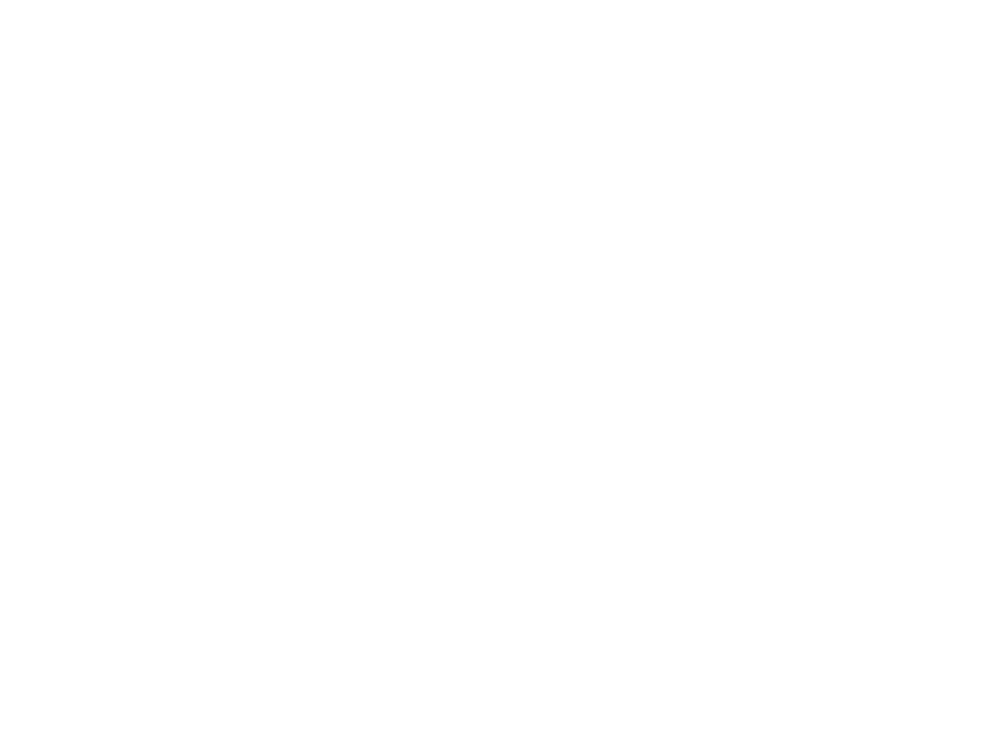

In [73]:
plt.grid()

for exp_data_L_c in SetA_c[1]:
    sns.histplot(data=exp_data_L_c['A2'], kde=True, binwidth=3e-4, lw=0, line_kws={'lw':2})
plt.savefig('temp.png')